Notebook showing basic usage.

Helper for loading `api_key` and not displaying in notebook

In [1]:
import json
from PIL import Image, ImageDraw, ImageFont
from typing import Dict, List, Tuple

import simplehound.core as hound

red=(255, 0, 0)
yellow=(255, 255, 0)
blue=(0, 255, 255)

In [35]:
api_key = 'your_key'

##  Detection API - people and faces
https://docs.sighthound.com/cloud/detection/

The Detection API returns the location of any people and faces found in an image. 

In [3]:
api = hound.cloud(api_key)

In [4]:
image_file_path = 'tests/images/people_car.jpg'

In [5]:
%%time
with open(image_file_path, "rb") as img_bytes:
    detections = api.detect(img_bytes.read())

CPU times: user 28 ms, sys: 8.15 ms, total: 36.2 ms
Wall time: 1.34 s


In [6]:
detections

{'image': {'width': 960, 'height': 480, 'orientation': 1},
 'objects': [{'type': 'person',
   'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}},
  {'type': 'person',
   'boundingBox': {'x': 833, 'y': 137, 'height': 268, 'width': 93}},
  {'type': 'face',
   'boundingBox': {'x': 305, 'y': 151, 'height': 28, 'width': 30},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9733,
    'age': 33,
    'ageConfidence': 0.7801,
    'frontal': True}},
  {'type': 'face',
   'boundingBox': {'x': 855, 'y': 147, 'height': 29, 'width': 24},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9834,
    'age': 37,
    'ageConfidence': 0.5096,
    'frontal': False}}],
 'requestId': '37e0610617c44550aeaf69817b1ef306'}

In [7]:
metadata = hound.get_metadata(detections)
metadata

{'image_width': 960,
 'image_height': 480,
 'requestId': '37e0610617c44550aeaf69817b1ef306'}

In [8]:
faces = hound.get_faces(detections)
faces

[{'gender': 'male',
  'age': 33,
  'boundingBox': {'x': 305, 'y': 151, 'height': 28, 'width': 30}},
 {'gender': 'male',
  'age': 37,
  'boundingBox': {'x': 855, 'y': 147, 'height': 29, 'width': 24}}]

In [9]:
people = hound.get_people(detections)
people

[{'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}},
 {'boundingBox': {'x': 833, 'y': 137, 'height': 268, 'width': 93}}]

## Plot detections
Here a [helper function](https://github.com/home-assistant/home-assistant/blob/dev/homeassistant/components/image_processing/__init__.py) is supplied for displaying the bounding boxes:

In [10]:
def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

In [11]:
img_width = metadata['image_width']
img_height = metadata['image_height']

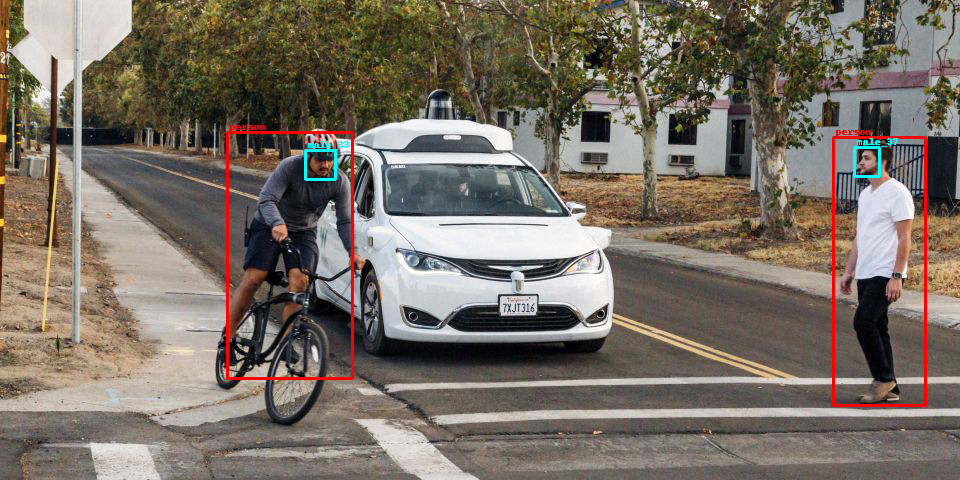

In [12]:
img = Image.open(image_file_path)
draw = ImageDraw.Draw(img)

for person in people:
    bbox = hound.bbox_to_tf_style(person['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text="person", color=red)

for face in faces:
    age = str(face['age'])
    gender = face['gender']
    face_description = f"{gender}_{age}"
    bbox = hound.bbox_to_tf_style(face['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text=face_description, color=blue)

img

##  Recognition API - Vehicle and License Plate
https://docs.sighthound.com/cloud/recognition/

There are 3 options:
- `licenseplate` : Performs recognition on all of the license plates detected in a submitted Image.
- `vehicle` : Performs recognition on all of the vehicles detected in a submitted Image.
- `vehicle,licenseplate`: This is similar to the `vehicle` recognition, but also includes `licenseplate` detection and recognition and pairing with vehicles. This operation can be noticeably slower than vehicle recogntion alone. When License Plates are paired with Vehicles, any detected Vehicle that does not have an associated License Plate will be more closely examined for a missed license plate. **Note** I found this option missed licenseplate detected by the `licenseplate` option

In [13]:
# image_file_path = 'tests/images/vehicle.jpg'
image_file_path = 'tests/images/two_cars.jpg'

#### `licenseplate`

In [14]:
%%time
with open(image_file_path, "rb") as img_bytes:
    licenseplate_recognitions = api.recognize(img_bytes.read(), "licenseplate")

CPU times: user 22.3 ms, sys: 3.86 ms, total: 26.1 ms
Wall time: 1.1 s


In [15]:
# licenseplate_recognitions

In [16]:
licenseplate_recognitions

{'image': {'width': 1024, 'height': 576, 'orientation': 1},
 'requestId': '01a9255929d74becb89721ae7ad722fa',
 'objects': [{'objectType': 'licenseplate',
   'licenseplateAnnotation': {'bounding': {'vertices': [{'x': 165, 'y': 285},
      {'x': 271, 'y': 285},
      {'x': 271, 'y': 340},
      {'x': 165, 'y': 340}]},
    'attributes': {'system': {'string': {'name': 'KBW468A',
       'confidence': 0.9629},
      'characters': [{'bounding': {'vertices': [{'y': 289, 'x': 178},
          {'y': 289, 'x': 196},
          {'y': 313, 'x': 196},
          {'y': 313, 'x': 178}]},
        'index': 0,
        'confidence': 0.9802,
        'character': 'K'},
       {'bounding': {'vertices': [{'y': 289, 'x': 196},
          {'y': 289, 'x': 214},
          {'y': 312, 'x': 214},
          {'y': 312, 'x': 196}]},
        'index': 1,
        'confidence': 0.9983,
        'character': 'B'},
       {'bounding': {'vertices': [{'y': 289, 'x': 214},
          {'y': 289, 'x': 232},
          {'y': 312, 'x': 23

In [17]:
plates = hound.get_license_plates(licenseplate_recognitions)
plates

[{'boundingBox': {'vertices': [{'x': 165, 'y': 285},
    {'x': 271, 'y': 285},
    {'x': 271, 'y': 340},
    {'x': 165, 'y': 340}]},
  'string': {'name': 'KBW468A', 'confidence': 0.9629},
  'region': {'name': 'UK', 'confidence': 0.7188}},
 {'boundingBox': {'vertices': [{'x': 750, 'y': 391},
    {'x': 894, 'y': 391},
    {'x': 894, 'y': 425},
    {'x': 750, 'y': 425}]},
  'string': {'name': 'KBW468A', 'confidence': 0.1687},
  'region': {'name': 'Finland', 'confidence': 0.3895}}]

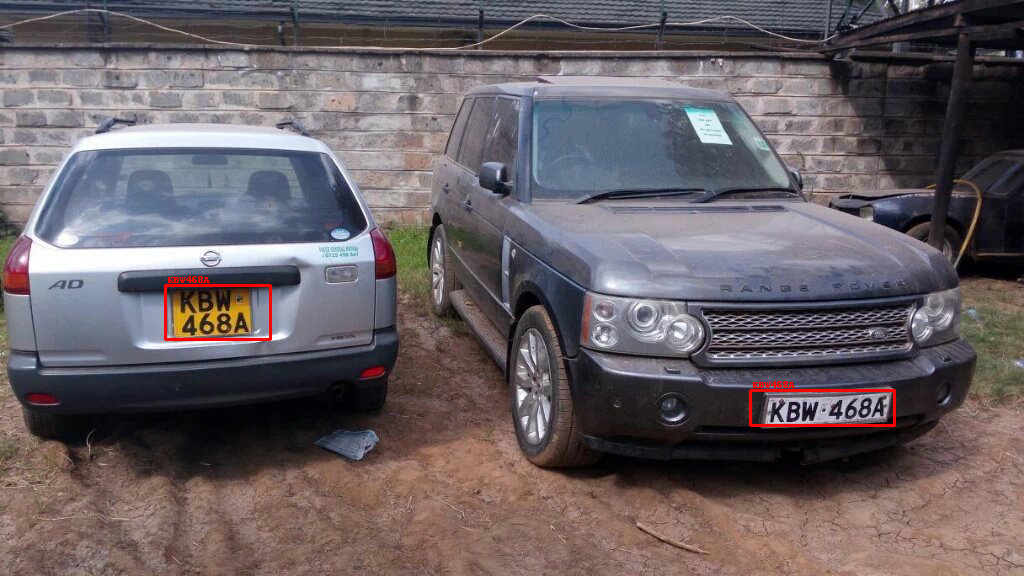

In [18]:
img = Image.open(image_file_path)
draw = ImageDraw.Draw(img)

for plate in plates:
    bbox = hound.bboxvert_to_tf_style(plate['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text=plate['string']['name'], color=red)

img

#### `vehicle`

In [19]:
%%time
with open(image_file_path, "rb") as img_bytes:
    vehicle_recognitions = api.recognize(img_bytes.read(), "vehicle")

#vehicle_recognitions

CPU times: user 20.2 ms, sys: 4.02 ms, total: 24.2 ms
Wall time: 1.35 s


In [29]:
def get_vehicles(detections: Dict) -> List[Dict]:
    """
    Get the list of the vehicles.
    """
    vehicles = []
    for obj in detections["objects"]:
        if not obj["objectType"] == "vehicle":
            continue
        vehicle = {}
        vehicle["boundingBox"] = obj['vehicleAnnotation']["bounding"]
        vehicle["recognitionConfidence"] = obj['vehicleAnnotation']["recognitionConfidence"]
        attributes = obj['vehicleAnnotation']['attributes']['system']
        vehicle["vehicleType"] = attributes["vehicleType"]
        vehicle["make"] = attributes["make"]["name"]
        vehicle["model"] = attributes["model"]["name"]
        vehicle["color"] = attributes["color"]["name"]
        if 'licenseplate' in obj['vehicleAnnotation']:
            vehicle['licenseplate'] = obj['vehicleAnnotation']['licenseplate']
        vehicles.append(vehicle)
    return vehicles

In [21]:
vehicles = get_vehicles(vehicle_recognitions)

In [22]:
vehicles

[{'boundingBox': {'vertices': [{'x': 8, 'y': 111},
    {'x': 407, 'y': 111},
    {'x': 407, 'y': 445},
    {'x': 8, 'y': 445}]},
  'recognitionConfidence': 0.064,
  'vehicleType': 'suv',
  'make': 'Lexus',
  'model': 'GX',
  'color': 'silver/grey'},
 {'boundingBox': {'vertices': [{'x': 430, 'y': 72},
    {'x': 988, 'y': 72},
    {'x': 988, 'y': 485},
    {'x': 430, 'y': 485}]},
  'recognitionConfidence': 0.6791,
  'vehicleType': 'suv',
  'make': 'Land Rover',
  'model': 'Range Rover',
  'color': 'black'}]

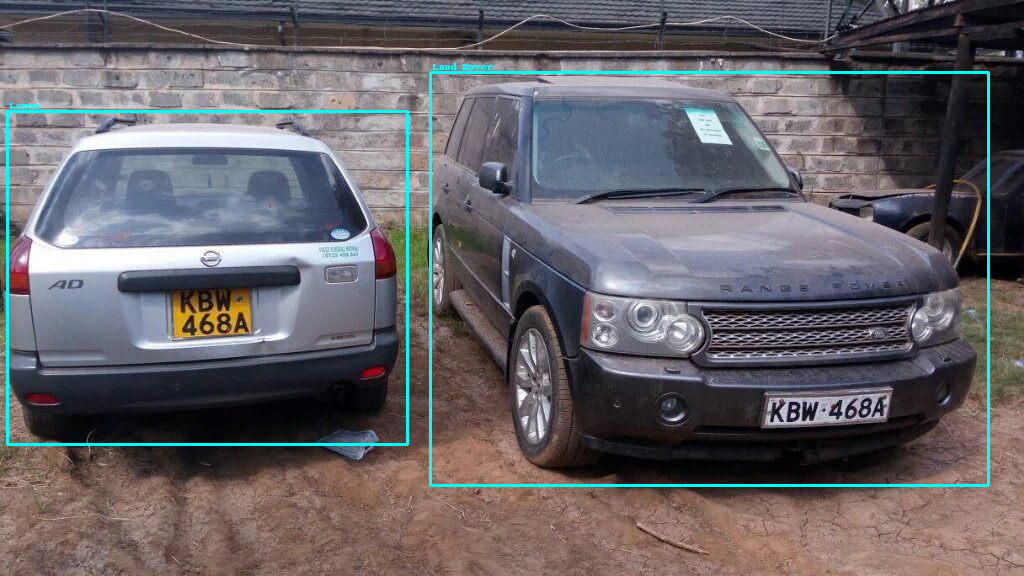

In [23]:
img = Image.open(image_file_path)
draw = ImageDraw.Draw(img)

for vehicle in vehicles:
    bbox = hound.bboxvert_to_tf_style(vehicle['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text=vehicle['make'], color=blue)

img

#### `vehicle,licenseplate`

Not yet supported

In [24]:
%%time
with open(image_file_path, "rb") as img_bytes:
    all_recognitions = api.recognize(img_bytes.read(), "vehicle,licenseplate")

# all_recognitions

CPU times: user 17.7 ms, sys: 4.6 ms, total: 22.3 ms
Wall time: 1.31 s


In [25]:
all_recognitions['objects'][0]

{'objectId': '_vehicle_76eba99d-9cdd-4763-91e7-839cc7ace94f',
 'vehicleAnnotation': {'bounding': {'vertices': [{'x': 8, 'y': 111},
    {'x': 407, 'y': 111},
    {'x': 407, 'y': 445},
    {'x': 8, 'y': 445}]},
  'recognitionConfidence': 0.064,
  'licenseplate': {'bounding': {'vertices': [{'x': 165, 'y': 285},
     {'x': 271, 'y': 285},
     {'x': 271, 'y': 340},
     {'x': 165, 'y': 340}]},
   'attributes': {'system': {'string': {'name': 'KBW468A',
      'confidence': 0.9629},
     'characters': [{'bounding': {'vertices': [{'y': 289, 'x': 178},
         {'y': 289, 'x': 196},
         {'y': 313, 'x': 196},
         {'y': 313, 'x': 178}]},
       'index': 0,
       'confidence': 0.9802,
       'character': 'K'},
      {'bounding': {'vertices': [{'y': 289, 'x': 196},
         {'y': 289, 'x': 214},
         {'y': 312, 'x': 214},
         {'y': 312, 'x': 196}]},
       'index': 1,
       'confidence': 0.9983,
       'character': 'B'},
      {'bounding': {'vertices': [{'y': 289, 'x': 214},
  

In [32]:
vehicles = get_vehicles(all_recognitions)

vehicles

[{'boundingBox': {'vertices': [{'x': 8, 'y': 111},
    {'x': 407, 'y': 111},
    {'x': 407, 'y': 445},
    {'x': 8, 'y': 445}]},
  'recognitionConfidence': 0.064,
  'vehicleType': 'suv',
  'make': 'Lexus',
  'model': 'GX',
  'color': 'silver/grey',
  'licenseplate': {'bounding': {'vertices': [{'x': 165, 'y': 285},
     {'x': 271, 'y': 285},
     {'x': 271, 'y': 340},
     {'x': 165, 'y': 340}]},
   'attributes': {'system': {'string': {'name': 'KBW468A',
      'confidence': 0.9629},
     'characters': [{'bounding': {'vertices': [{'y': 289, 'x': 178},
         {'y': 289, 'x': 196},
         {'y': 313, 'x': 196},
         {'y': 313, 'x': 178}]},
       'index': 0,
       'confidence': 0.9802,
       'character': 'K'},
      {'bounding': {'vertices': [{'y': 289, 'x': 196},
         {'y': 289, 'x': 214},
         {'y': 312, 'x': 214},
         {'y': 312, 'x': 196}]},
       'index': 1,
       'confidence': 0.9983,
       'character': 'B'},
      {'bounding': {'vertices': [{'y': 289, 'x': 21

In [33]:
plates = hound.get_license_plates(all_recognitions)

plates

[]

Annoyingly we cannot reuse `hound.get_license_plates` as the data appears to be in a different format

In [34]:
vehicles[0]['licenseplate']

{'bounding': {'vertices': [{'x': 165, 'y': 285},
   {'x': 271, 'y': 285},
   {'x': 271, 'y': 340},
   {'x': 165, 'y': 340}]},
 'attributes': {'system': {'string': {'name': 'KBW468A', 'confidence': 0.9629},
   'characters': [{'bounding': {'vertices': [{'y': 289, 'x': 178},
       {'y': 289, 'x': 196},
       {'y': 313, 'x': 196},
       {'y': 313, 'x': 178}]},
     'index': 0,
     'confidence': 0.9802,
     'character': 'K'},
    {'bounding': {'vertices': [{'y': 289, 'x': 196},
       {'y': 289, 'x': 214},
       {'y': 312, 'x': 214},
       {'y': 312, 'x': 196}]},
     'index': 1,
     'confidence': 0.9983,
     'character': 'B'},
    {'bounding': {'vertices': [{'y': 289, 'x': 214},
       {'y': 289, 'x': 232},
       {'y': 312, 'x': 232},
       {'y': 312, 'x': 214}]},
     'index': 2,
     'confidence': 0.994,
     'character': 'W'},
    {'bounding': {'vertices': [{'y': 313, 'x': 179},
       {'y': 313, 'x': 198},
       {'y': 336, 'x': 198},
       {'y': 336, 'x': 179}]},
     'ind